# Hydrostatic pressure as a predictor of star formation in nearby galaxies

The objective of this project is to present a concise version of my analysis of the relation between the hydrostatic pressure and star formation rate density on local scales in galaxies observed as part of the ACA-EDGE survey, where I compare said relation to the ones previously established between the stellar mass density, molecular gas mass density, and star formation rate density. My goal in this article is not to go too deeply into the physics behind these phenomena, but rather to focus on the data analysis and main results. I have included an additional section at the end where I use machine learning to identify the features that are most important in predicting the star formation rate densities from the data observed.

I begin by importing several packages used throughout this notebook, and adjusting parameters for formatting plots:

In [1]:
import numpy as np
import pandas as pd
from astropy import units as u
from astropy import constants as const
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [2]:
plt.rcParams['figure.facecolor'] = 'white'
from matplotlib import rc
rc('font',family='DejaVu Sans',size=12)
rc('mathtext',fontset='dejavusans')
rc('figure', figsize=(1.41421356237*6.,6.)) 
rc('lines', linewidth=1.5,marker='.',markersize=1 )
rc('axes', linewidth=1.5,labelsize=14)
rc(('xtick.major','ytick.major'), size=5.2,width=1.5)
rc(('xtick.minor','ytick.minor'), size=3.2,width=1.5,visible=True)
rc(('xtick','ytick'), labelsize=10, direction='in' )
rc(('xtick'), top=True,bottom=True ) # For some reason you have to do these seperately
rc(('ytick'), left=True,right=True )
rc('legend',numpoints=1,scatterpoints=1,labelspacing=0.2,fontsize=9,fancybox=True,handlelength=1.5,
            handletextpad=0.5)
rc('savefig', dpi=150,format='pdf',bbox='tight' )
rc('errorbar',capsize=3.)

The data used in this project is contained in two tables, `ACA_EDGE_galaxies.csv` and `ACA_EDGE_pixels.csv`. The first one contains global properties for each one of the 40 galaxies selected for this study. The second table contains local measurements made for individual resolved picture elements (or pixels) from the galaxies in the study. These resolved measurments are the main focus of this project. Here I import the two tables and check the columns contained in each one:

In [ ]:
folderpath = '' # Path to data files
galaxies = pd.read_csv(folderpath+'ACA_EDGE_galaxies.csv')
galaxies['Source_id'] = galaxies['Source_id'].astype("category")
galaxies['Q_Stage'] = galaxies['Q_Stage'].astype("category")
print(galaxies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Source_id        40 non-null     category
 1   Q_Stage          40 non-null     category
 2   Inclination_deg  40 non-null     float64 
 3   PA_deg           40 non-null     float64 
 4   Area_kpc2        40 non-null     float64 
 5   Re_kpc           40 non-null     float64 
dtypes: category(2), float64(4)
memory usage: 3.0 KB
None


In [3]:
pixels = pd.read_csv(folderpath+'ACA_EDGE_pixels.csv')
pixels['Source_id'] = pixels['Source_id'].astype("category")
pixels['SF_Passive'] = pixels['SF_Passive'].astype("category")
print(pixels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67869 entries, 0 to 67868
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Source_id      67869 non-null  category
 1   RA             67869 non-null  float64 
 2   DEC            67869 non-null  float64 
 3   Rgal_kpc       67869 non-null  float64 
 4   T_gal          67869 non-null  float64 
 5   SF_Passive     67869 non-null  category
 6   S_Mstar        67869 non-null  float64 
 7   eS_Mstar       67869 non-null  float64 
 8   S_SFR          45870 non-null  float64 
 9   eS_SFR         45870 non-null  float64 
 10  Z_O3N2         63407 non-null  float64 
 11  eZ_O3N2        63407 non-null  float64 
 12  alphaCO_O3N2   63407 non-null  float64 
 13  ealphaCO_O3N2  63407 non-null  float64 
 14  CO_int         32535 non-null  float64 
 15  eCO_int        32535 non-null  float64 
 16  CO_nchannels   67869 non-null  int64   
 17  CO_vdisp       32535 non-null  

Now I merge the two tables making use of the `Source_id` column, and also drop some columns that will not be used here:

In [5]:
Database = galaxies.merge(pixels, on='Source_id', how='left')
Database.drop(columns=['RA','DEC','PA_deg','Area_kpc2','T_gal','Z_O3N2','eZ_O3N2','CO_nchannels'], inplace=True)
Database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67869 entries, 0 to 67868
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Source_id        67869 non-null  category
 1   Q_Stage          67869 non-null  category
 2   Inclination_deg  67869 non-null  float64 
 3   Re_kpc           67869 non-null  float64 
 4   Rgal_kpc         67869 non-null  float64 
 5   SF_Passive       67869 non-null  category
 6   S_Mstar          67869 non-null  float64 
 7   eS_Mstar         67869 non-null  float64 
 8   S_SFR            45870 non-null  float64 
 9   eS_SFR           45870 non-null  float64 
 10  alphaCO_O3N2     63407 non-null  float64 
 11  ealphaCO_O3N2    63407 non-null  float64 
 12  CO_int           32535 non-null  float64 
 13  eCO_int          32535 non-null  float64 
 14  CO_vdisp         32535 non-null  float64 
dtypes: category(3), float64(12)
memory usage: 6.4 MB


## Scaling relations

The main quantities of interest here are the stellar mas density ($\Sigma_\star$), the star formation density ($\Sigma_\mathrm{SFR}$), the molecular gas mass density ($\Sigma_\mathrm{mol}$), and the hydrostatic pressure ($P_\mathrm{h}$). The first two are already found in the data tables, but the other two have to be calculated from other columns in the tables. Previous studies have shown that these quantities are related to each other and that those relations can be described by power laws, which means that the logarithm of the quantities are related to each other by simple linear relations, which are named as follows:

The resolved star-forming main sequence (rSFMS):

#### $\mathrm{log\left(\frac{\Sigma_{SFR}}{M_\odot yr^{-1} kpc^{-2}}\right)} = b_1 + m_1 $ $\mathrm{log\left(\frac{\Sigma_\star}{M_\odot kpc^{-2}}\right)}$

The Schmitt-Kennicutt law (rSK):

#### $\mathrm{log\left(\frac{\Sigma_{SFR}}{M_\odot yr^{-1} kpc^{-2}}\right)} = b_2 + m_2 $ $\mathrm{log\left(\frac{\Sigma_{mol}}{M_\odot kpc^{-2}}\right)}$

The resolved molecular gas main sequence (rMGMS):

#### $\mathrm{log\left(\frac{\Sigma_{mol}}{M_\odot kpc^{-2}}\right)} = b_3 + m_3 $ $\mathrm{log\left(\frac{\Sigma_\star}{M_\odot kpc^{-2}}\right)}$

And finally th star formation rate - pressure relation:

#### $\mathrm{log\left(\frac{\Sigma_{SFR}}{M_\odot yr^{-1} kpc^{-2}}\right)} = b_4 + m_4 $ $\mathrm{log}\left(\frac{P_\mathrm{h}}{k_\mathrm{B} \mathrm{K cm}^{-3}}\right)$

The exact values of the various parameters $b_n$ and $m_n$ are subject to debate and may vary from one study to another. In this project I attempt to calculate those values using simple ordinary least squares (OLS) fitting, and also compare them to previous results in the literature.

In [6]:
# Labels for plots
logSFR_label = r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)'
logMstar_label = r'log($\Sigma_\star$/M$_\odot$kpc$^{-2}$)'
logMmol_label = r'log($\Sigma_\mathrm{mol}$/M$_\odot$kpc$^{-2}$)'
logPh_label = r'log($P_\mathrm{h}$/k$_\mathrm{B}$cm$^{-3}$K)'
labels = [logMstar_label, logSFR_label, logMmol_label, logPh_label]

In [7]:
# Values of important constants in useful units
G = const.G.to(u.kpc**3/(u.Msun*u.s**2)).value # gravitational constant
k_B = (const.k_B).to(u.Msun*u.kpc**2/u.s**2/u.K).value # Boltzmann constant
S_H1 = 7.*10**6 # average atomic gas mass surface density in M_sun kpc^-2
Z_sun = 4.9*10**-4 # solar metallicity, Baumgartner & Mushotzky 2006
alphaCO_MW = 4.3 # conversion factor in M_sun/(K km s^-1 pc^2), from Milky Way observations

## Calculating important quantities

Here I define functions to calculate some important quantities from the data in the tables, such as the molecular gas mass surface density: 

#### $\Sigma_\mathrm{mol} = \frac{\alpha_\mathrm{CO}}{R_{2 1}} \mathrm{cos}(i) I_\mathrm{CO(2-1)}$

In [8]:
def S_mol(CO_int,inc,alphaCO=alphaCO_MW,R_21=0.65,unc=False,eCO_int=None,ealpha_CO=alphaCO_MW*0.3):
    cos = np.cos(np.deg2rad(inc))
    Smol = CO_int*cos*alphaCO*10**6/R_21
    if unc:
        if (eCO_int is None) or (ealpha_CO is None):
            print('Need to provide error for integrated intensity or alphaCO')
            return None
        else:
            eSmol = Smol*np.sqrt((eCO_int/CO_int)**2 + (ealpha_CO/alphaCO)**2)
            return Smol, eSmol
    else:
        return Smol

The stellar velocity dispersion:

#### $\sigma_\mathrm{\star,z} = \sqrt{2\pi G \Sigma_\star h_\mathrm{s}}$

In [9]:
def star_vdisp(S_Mstar,Re):
    hs = Re/(1.68*7.3)
    return np.sqrt(2*np.pi*G*S_Mstar*hs)*u.kpc.to(u.km)

And finally the hydrostatic pressure:

#### $P_\mathrm{h} = \frac{\pi}{2} G \Sigma_\mathrm{gas} \left( \Sigma_\mathrm{gas} + \frac{\sigma_\mathrm{gas}}{\sigma_\mathrm{\star,z}}\Sigma_\star \right)$

In [10]:
def Ph(S_mol,S_Mstar,star_vdisp,CO_vdisp=11,unc=False,eS_mol=None,eS_Mstar=None,Re=None):
    S_gas = S_mol+S_H1
    Ph = (np.pi*G/2)*S_gas*(S_gas+S_Mstar*CO_vdisp/star_vdisp)
    Ph = Ph/k_B/(u.kpc**3).to(u.cm**3)
    
    if unc:
        if (eS_mol is None) or (eS_Mstar is None):
            print('Need to provide error for stellar or molecualer gas mass surface density')
            return None
        else:
            hs = Re/(1.68*7.3)
            COvdisp_root = CO_vdisp*np.sqrt(np.pi*G*S_Mstar/hs/8)/u.kpc.to(u.km)
            ePh = np.sqrt(((np.pi*G*S_gas + COvdisp_root)*eS_mol)**2 + (S_gas*COvdisp_root*eS_Mstar/S_Mstar/2)**2)
            ePh = ePh/k_B/(u.kpc**3).to(u.cm**3)
            return Ph, ePh
    else:
        return Ph

Now I use these functions to calculate the desired quantities and store them in new columns:

In [11]:
Database['star_vdisp'] = star_vdisp(Database['S_Mstar'],Database['Re_kpc'])
Database['S_mol'] = S_mol(Database['CO_int'],Database['Inclination_deg'],alphaCO=Database['alphaCO_O3N2'])
Database['Ph'] = Ph(Database['S_mol'],Database['S_Mstar'],Database['star_vdisp'])

Many of these quantities are logarithmically distributed, so here I calculate their base-10 logarithms and store them in new columns: 

*(The runtime warning is due to some rows having a value of zero, which cannot be converted into logarithmic space. These will be treated as missing values and we can safely ignore this warning.)*

In [ ]:
Database['log_S_Mstar'] = np.log10(Database['S_Mstar'])
Database['log_S_SFR'] = np.log10(Database['S_SFR'])
Database['log_S_mol'] = np.log10(Database['S_mol'])
Database['log_Ph'] = np.log10(Database['Ph'])

c:\Users\bruno\anaconda3\envs\py312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Galaxies classified by quenching stages

One important property is found in the `Q_stage` column, which refers to the *quenching stage* of each galaxy. Queching is basically the process of star-formation being shut down in galaxies, and this column refers to different stages in such process. These stages go from star-forming (labeled SF) which means the is active star formation throughout the galaxy, to fully retired (labeled fR), which means there is very little to no star formation at all. We can check how many galaxies of each type are found in the database:

In [14]:
galaxies['Q_Stage'].value_counts()

Q_Stage
SF     13
MX      6
cQ      6
fR      6
nR      5
QnR     4
Name: count, dtype: int64

We can also check how many of our quantities of interest are available in the pixels belonging to galaxies of each type:

In [15]:
stages = ['SF','QnR','cQ','MX','nR','fR']
Database.groupby('Q_Stage',observed=False).agg('count')[['log_S_Mstar','log_S_SFR','log_S_mol','log_Ph']].loc[stages,:]

,log_S_Mstar,log_S_SFR,log_S_mol,log_Ph
Q_Stage,,,,
SF,21961,19825,16288,16288
QnR,8290,6946,6193,6193
cQ,10209,7694,5438,5438
MX,9146,5077,2781,2781
nR,8281,2914,1192,1192
fR,9982,3385,127,127


Notice that the numbers in the last two columns decrease significantly towards the final stages of the quenching process. This is not only beacuse there are fewer galaxies of these types, but also because retired galaxies tend to contain lower quantities of molecular gas, which lowers the available measurements of both $\Sigma_\mathrm{mol}$ and $P\mathrm{h}$. Now I use boxplots to briefly compare the distributions of the main quantities of interest across quenching stages:

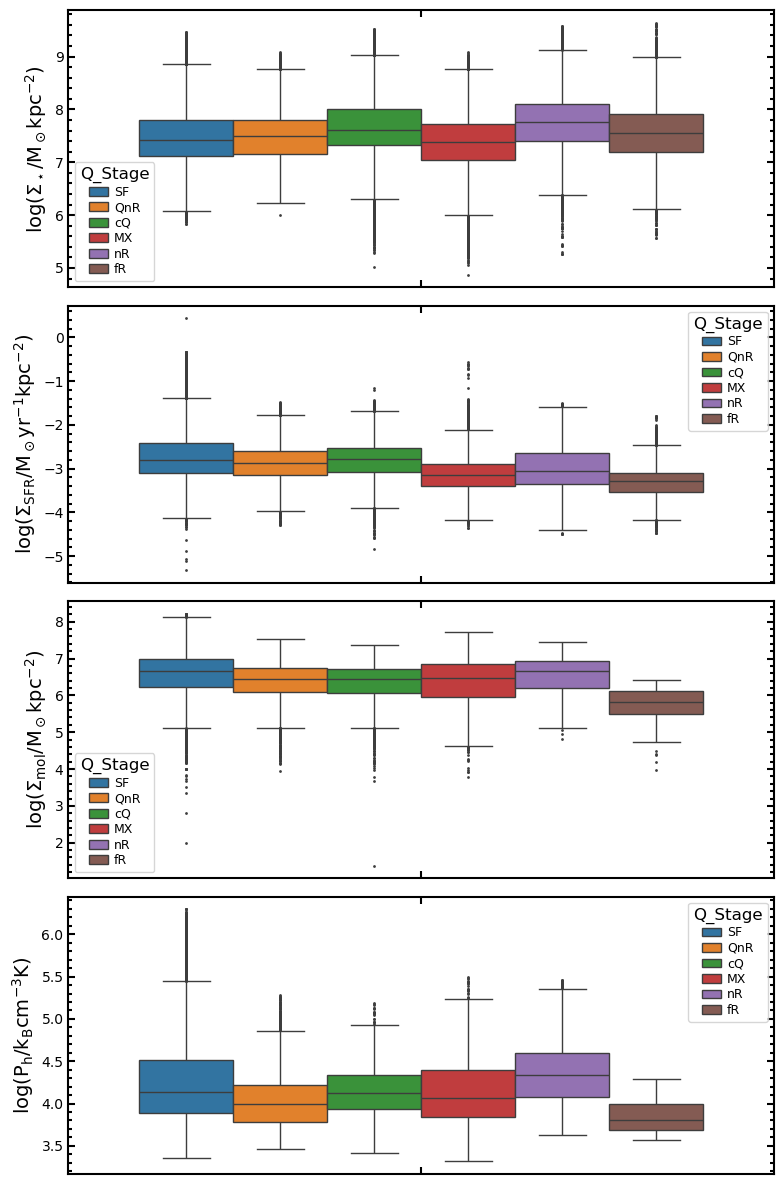

In [16]:
fig, ax = plt.subplots(4,1,figsize=(8,12))
sns.boxplot(y='log_S_Mstar',hue='Q_Stage',data=Database,hue_order=stages, ax=ax[0])
sns.boxplot(y='log_S_SFR',hue='Q_Stage',data=Database,hue_order=stages, ax=ax[1])
sns.boxplot(y='log_S_mol',hue='Q_Stage',data=Database,hue_order=stages, ax=ax[2])
sns.boxplot(y='log_Ph',hue='Q_Stage',data=Database,hue_order=stages, ax=ax[3])
for axis, label in zip(ax.flatten(), labels):
    axis.set_ylabel(label)
fig.tight_layout()
plt.show()

There are two main features to notice here. First, while there is no discernible patter for the distributions of the stellar mass (the top panel), the distributions of the star formation rate (second panel) consistently decrease going from SF to fR, which is expected as the quenching process is characterized by lowering of the star formation rate. Note also that the distributions for molecular gas mass and hydrostatic pressure (second-to-last and bottom panels, respectively) show very low values for the fR stage, which is also consistent which the low molecular gas found in these galaxies as explained above.

The second feature to notice is the long tails found in the upper values of the distributions of star formation rate and pressure (second and bottom panels, respectively) for SF galaxies. This tells us that the highest value sof pressure are found in the most active galaxies, and that those probably correspond to the highest values of star formation rates, though this last point will be confirmed later.

## Pixels classified by ionization from star-forming activity

Another categorical within the data is found in the `SF_Passive` column, which refers to a classification of individual pixels rather than whole galaxies. *SF* refers to star-forming *pixels*, which means that the ionization in these regions is taken as a tracer of star formation. *Passive* pixels are the ones where the ionization does not trace star formation, but this does not mean that there is no star formation at all. These last regions have usually been left out of studies of scaling relations, but I have included them here after using a different tracer to measure the (admittedly low) amount of star formation in them. Again, we can see how many pixels of each type are found in the database, and how many measurements are available for each type:

In [17]:
Database['SF_Passive'].value_counts()

SF_Passive
Passive    51381
SF         16488
Name: count, dtype: int64

In [18]:
SF_P = ['SF','Passive']
Database.groupby('SF_Passive',observed=False).agg('count')[['log_S_Mstar','log_S_SFR','log_S_mol','log_Ph']].loc[SF_P,:]

,log_S_Mstar,log_S_SFR,log_S_mol,log_Ph
SF_Passive,,,,
SF,16488,16459,12344,12344
Passive,51381,29382,19675,19675


Notice that there are many more passive pixels in the database, but that the number of available measurements decreases going from stellar mass to hydrostatic pressure. That's because in spite of the method used to retrieve the star formation rates in passive pixels, these usually contain lower values of star formation, which are often consistent with being zero. They also usually feature low or none molecular gas, which in turn lowers the available measurements of hydrostatic pressure. This can be further corroborated by checking boxplots for these quantities as follows. Note that values of stellar mass are very similar for SF and passive pixels, while in the case of all other quantities, the values are consistently lower for passive pixels than for SF ones:

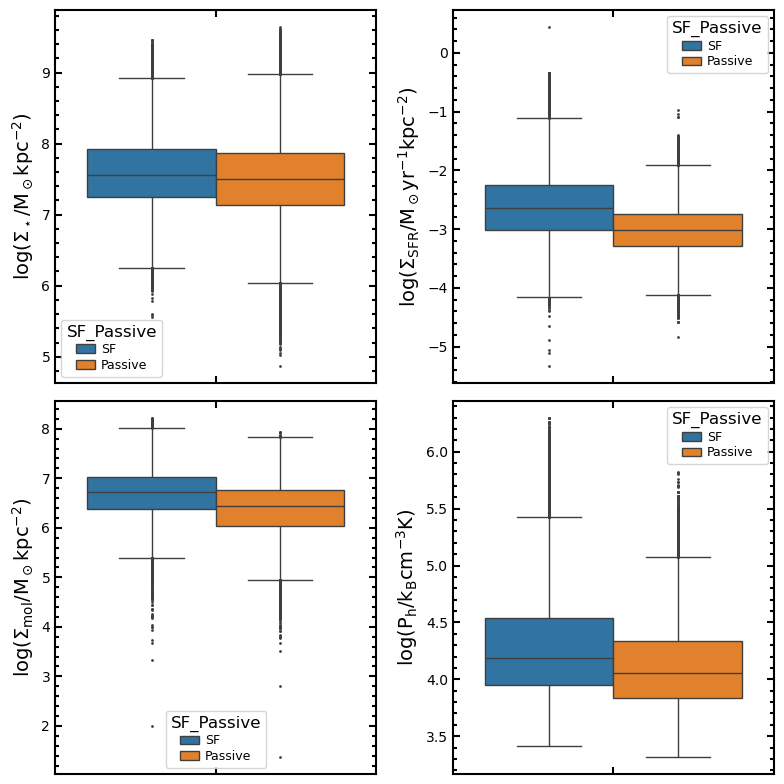

In [19]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
sns.boxplot(y='log_S_Mstar',hue='SF_Passive',data=Database,hue_order=SF_P, ax=ax[0,0])
sns.boxplot(y='log_S_SFR',hue='SF_Passive',data=Database,hue_order=SF_P, ax=ax[0,1])
sns.boxplot(y='log_S_mol',hue='SF_Passive',data=Database,hue_order=SF_P, ax=ax[1,0])
sns.boxplot(y='log_Ph',hue='SF_Passive',data=Database,hue_order=SF_P, ax=ax[1,1])
for axis, label in zip(ax.flatten(), labels):
    axis.set_ylabel(label)
fig.tight_layout()
plt.show()

## Results of linear regression for all 4 relations

Now we can separate the data into a sample of SF pixels and one of passive pixels. Then I can perform a linear fit to each sample (and the combined samples) for each of the relations of interest.

In [ ]:
Database_SF = Database[Database['SF_Passive']=='SF']
Database_Passive = Database[Database['SF_Passive']=='Passive']
relations = ['SFR-Mstar','SFR-Mmol','Mmol-Mstar','SFR-Ph']
xvars = ['log_S_Mstar','log_S_mol','log_S_Mstar','log_Ph']
yvars = ['log_S_SFR','log_S_SFR','log_S_mol','log_S_SFR']

In [ ]:
SF_fits = []
for relation, xvar, yvar in zip(relations,xvars,yvars):
    data = Database_SF[[xvar, yvar]].dropna()
    pearson = linregress(data[xvar],data[yvar])
    df = pd.DataFrame({'Relation':relation,'slope':[pearson.slope],'intercept':[pearson.intercept],'rvalue':[pearson.rvalue],'pvalue':[pearson.pvalue],'stderr':[pearson.stderr]})
    SF_fits.append(df)
SF_fits = pd.concat(SF_fits,ignore_index=True)
SF_fits

,Relation,slope,intercept,rvalue,pvalue,stderr
0,SFR-Mstar,0.938932,-9.744150,0.830735,0.0,0.004904
1,SFR-Mmol,0.779067,-7.671640,0.740474,0.0,0.006368
2,Mmol-Mstar,0.822521,0.335977,0.746971,0.0,0.006590
3,SFR-Ph,1.023102,-6.872558,0.868441,0.0,0.005260


Let's look first at the results for the SF sample, shown above. The relation between pressure and star formation rate has the highest r-value of all fits, indicating the strongest correlation among all probed relations. Notice that this relation, along with that between stellar mass and star formation rate, has the highest slope, and the lowest variance in the slope. We can compare these results to those from previous studies as follows: (the first three are taken from Sánchez et. al. 2021 and the last one is taken from Barrera-Ballesteros et. al. 2021)

In [26]:
prev_results = pd.DataFrame({'Relation':relations,'slope':[1.02,0.98,0.93,0.95],'intercept':[-10.22,-8.89,-0.49,-6.5]})
prev_results

,Relation,slope,intercept
0,SFR-Mstar,1.02,-10.22
1,SFR-Mmol,0.98,-8.89
2,Mmol-Mstar,0.93,-0.49
3,SFR-Ph,0.95,-6.50


The most important difference between these results and the ones obtained by me is that in the previous studies all 4 slopes have values very close to 1, while in the fits presented here only the first and last relations have slopes close to 1. We can now compare these results accross 3 different samples: the SF sample, the passive sample, and the combined, full sample.

In [ ]:
total_fits = []
for relation, xvar, yvar in zip(relations,xvars,yvars):
    data = Database[[xvar, yvar]].dropna()
    pearson = linregress(data[xvar],data[yvar])
    df = pd.DataFrame({'Relation':relation,'slope':[pearson.slope],'intercept':[pearson.intercept],'rvalue':[pearson.rvalue],'pvalue':[pearson.pvalue],'stderr':[pearson.stderr]})
    total_fits.append(df)
total_fits = pd.concat(total_fits,ignore_index=True)

In [ ]:
Passive_fits = []
for relation, xvar, yvar in zip(relations,xvars,yvars):
    data = Database_Passive[[xvar, yvar]].dropna()
    pearson = linregress(data[xvar],data[yvar])
    df = pd.DataFrame({'Relation':relation,'slope':[pearson.slope],'intercept':[pearson.intercept],'rvalue':[pearson.rvalue],'pvalue':[pearson.pvalue],'stderr':[pearson.stderr]})
    Passive_fits.append(df)
Passive_fits = pd.concat(Passive_fits,ignore_index=True)

In [52]:
print('Fit results for SF sample:\n',SF_fits,'\n')
print('Fit results for total sample:\n',total_fits,'\n')
print('Fit results for Passive sample:\n',Passive_fits)

Fit results for SF sample:
      Relation     slope  intercept    rvalue  pvalue    stderr
0   SFR-Mstar  0.938932  -9.744150  0.830735     0.0  0.004904
1    SFR-Mmol  0.779067  -7.671640  0.740474     0.0  0.006368
2  Mmol-Mstar  0.822521   0.335977  0.746971     0.0  0.006590
3      SFR-Ph  1.023102  -6.872558  0.868441     0.0  0.005260 

Fit results for total sample:
      Relation     slope  intercept    rvalue  pvalue    stderr
0   SFR-Mstar  0.925185  -9.702894  0.887787     0.0  0.002240
1    SFR-Mmol  0.627773  -6.720475  0.696353     0.0  0.004090
2  Mmol-Mstar  0.673404   1.326309  0.609370     0.0  0.004897
3      SFR-Ph  1.024831  -6.914556  0.863885     0.0  0.003777 

Fit results for Passive sample:
      Relation     slope  intercept    rvalue  pvalue    stderr
0   SFR-Mstar  0.861893  -9.277985  0.928237     0.0  0.002015
1    SFR-Mmol  0.383797  -5.245296  0.554518     0.0  0.005113
2  Mmol-Mstar  0.553173   2.144069  0.527000     0.0  0.006360
3      SFR-Ph  0.93346

The first thing to notice is that the r-values for the first and last relations remain strong among all 3 smaples, while for the other 2 relations, the r-value decresases from the SF sample to the total sample, and decreases even further for the passive sample. A similar behavior is seen with the slopes, which remain high in all 3 samples for the first 2 relations, but for the other 2 relations they decrease significantly for the passive sample, making the relation much flatter. For the total sample, the slope is found somewhere in the middle between the results of the other two samples. This can be noticed more easily with some visualizations.

## Visualizing fits

Now that we have the results of the linear fits, we can visualize them along with the actual data in some plots. In the following plots to visualize each of the relations of interest, the greyscale in the background representes the density of datapoints in the 2-dimensional space of the quantities in question; the blue dashed line represents the resulting fit for the SF sample, the red line represents the result for the passive sample, and the green line represents the result for both samples combined. On each plot, the black dashed line represents a result from the literature to which to compare these results.

In [ ]:
def plothexbin(ax, x, y, x_label, y_label):
    im = ax.hexbin(x, y, mincnt=1, cmap='binary')
    fig.colorbar(im, ax=ax, orientation='vertical', label=r'Pixels per bin')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    xmin, xmax = np.nanpercentile(x, [0.01, 99.99])
    ymin, ymax = np.nanpercentile(y, [0.01, 99.99])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    return xmin, xmax

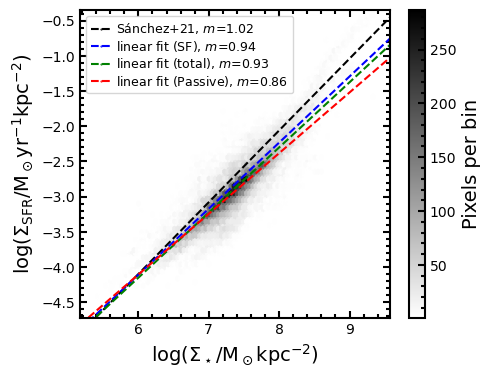

In [43]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
xmin, xmax = plothexbin(ax, Database['log_S_Mstar'], Database['log_S_SFR'], logMstar_label, logSFR_label)
pre = prev_results.loc[0,:]
ax.plot([xmin,xmax],[xmin*pre['slope']+pre['intercept'],xmax*pre['slope']+pre['intercept']],c='k',ls='--',label='Sánchez+21'+f', $m$={pre['slope']:.3}')
fit = SF_fits.loc[0,:]
ax.plot([xmin,xmax],[xmin*fit['slope']+fit['intercept'],xmax*fit['slope']+fit['intercept']],c='b',ls='--',label='linear fit (SF)'+f', $m$={fit['slope']:.2}')
fit = total_fits.loc[0,:]
ax.plot([xmin,xmax],[xmin*fit['slope']+fit['intercept'],xmax*fit['slope']+fit['intercept']],c='g',ls='--',label='linear fit (total)'+f', $m$={fit['slope']:.2}')
fit = Passive_fits.loc[0,:]
ax.plot([xmin,xmax],[xmin*fit['slope']+fit['intercept'],xmax*fit['slope']+fit['intercept']],c='r',ls='--',label='linear fit (Passive)'+f', $m$={fit['slope']:.2}')
ax.legend(loc='upper left')
plt.show()

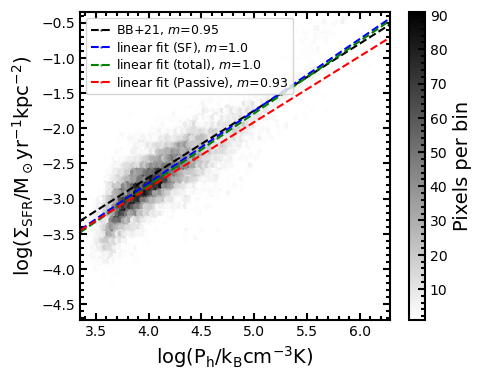

In [53]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
xmin, xmax = plothexbin(ax, Database['log_Ph'], Database['log_S_SFR'], logPh_label, logSFR_label)
pre = prev_results.loc[3,:]
ax.plot([xmin,xmax],[xmin*pre['slope']+pre['intercept'],xmax*pre['slope']+pre['intercept']],c='k',ls='--',label='BB+21'+f', $m$={pre['slope']:.3}')
fit = SF_fits.loc[3,:]
ax.plot([xmin,xmax],[xmin*fit['slope']+fit['intercept'],xmax*fit['slope']+fit['intercept']],c='b',ls='--',label='linear fit (SF)'+f', $m$={fit['slope']:.2}')
fit = total_fits.loc[3,:]
ax.plot([xmin,xmax],[xmin*fit['slope']+fit['intercept'],xmax*fit['slope']+fit['intercept']],c='g',ls='--',label='linear fit (total)'+f', $m$={fit['slope']:.2}')
fit = Passive_fits.loc[3,:]
ax.plot([xmin,xmax],[xmin*fit['slope']+fit['intercept'],xmax*fit['slope']+fit['intercept']],c='r',ls='--',label='linear fit (Passive)'+f', $m$={fit['slope']:.2}')
ax.legend(loc='upper left')
plt.show()

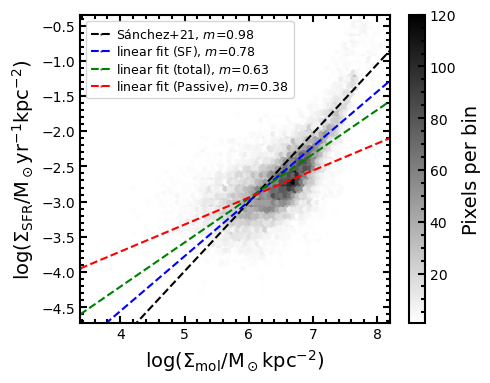

In [55]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
xmin, xmax = plothexbin(ax, Database['log_S_mol'], Database['log_S_SFR'], logMmol_label, logSFR_label)
pre = prev_results.loc[1,:]
ax.plot([xmin,xmax],[xmin*pre['slope']+pre['intercept'],xmax*pre['slope']+pre['intercept']],c='k',ls='--',label='Sánchez+21'+f', $m$={pre['slope']:.3}')
fit = SF_fits.loc[1,:]
ax.plot([xmin,xmax],[xmin*fit['slope']+fit['intercept'],xmax*fit['slope']+fit['intercept']],c='b',ls='--',label='linear fit (SF)'+f', $m$={fit['slope']:.2}')
fit = total_fits.loc[1,:]
ax.plot([xmin,xmax],[xmin*fit['slope']+fit['intercept'],xmax*fit['slope']+fit['intercept']],c='g',ls='--',label='linear fit (total)'+f', $m$={fit['slope']:.2}')
fit = Passive_fits.loc[1,:]
ax.plot([xmin,xmax],[xmin*fit['slope']+fit['intercept'],xmax*fit['slope']+fit['intercept']],c='r',ls='--',label='linear fit (Passive)'+f', $m$={fit['slope']:.2}')
ax.legend(loc='upper left')
plt.show()

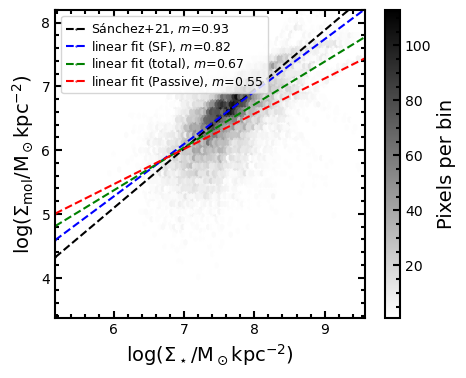

In [54]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
xmin, xmax = plothexbin(ax, Database['log_S_Mstar'], Database['log_S_mol'], logMstar_label, logMmol_label)
pre = prev_results.loc[2,:]
ax.plot([xmin,xmax],[xmin*pre['slope']+pre['intercept'],xmax*pre['slope']+pre['intercept']],c='k',ls='--',label='Sánchez+21'+f', $m$={pre['slope']:.3}')
fit = SF_fits.loc[2,:]
ax.plot([xmin,xmax],[xmin*fit['slope']+fit['intercept'],xmax*fit['slope']+fit['intercept']],c='b',ls='--',label='linear fit (SF)'+f', $m$={fit['slope']:.2}')
fit = total_fits.loc[2,:]
ax.plot([xmin,xmax],[xmin*fit['slope']+fit['intercept'],xmax*fit['slope']+fit['intercept']],c='g',ls='--',label='linear fit (total)'+f', $m$={fit['slope']:.2}')
fit = Passive_fits.loc[2,:]
ax.plot([xmin,xmax],[xmin*fit['slope']+fit['intercept'],xmax*fit['slope']+fit['intercept']],c='r',ls='--',label='linear fit (Passive)'+f', $m$={fit['slope']:.2}')
ax.legend(loc='upper left')
plt.show()

As can be seen in the plots above, the relation between the stellar mass and the star formation rate and the one between the hydrostatic pressure and the star formation rate (first 2 plots) remain without much change across all 3 samples, and are also close to the relations found in previous studies. On the other hand, the relations involving the molecular gas mass become much flatter for the total and passive samples compared to the SF sample, and also deviate heavily from the previously cited results. This suggests that the stellar mass and hydrostatic pressure are better predictors of star formation rate, even in those regions with weak ionization that does not trace star formation.

## Using machine learning to uncover important features

Now that we have established that stellar mass and pressure show the strongest correlations with star formation rate, I will use a machine learning model to uncover which is the best predictor of star formation. Specifically, I will use a Lasso model, which is frequently used for feature selection since it tends to reduce to zero uninmportant features. The features to test will be the stellar mass, molecular gas mass, and hydrostatic pressure. Following the approach of Ellison et. al. 2024, I will additionally include 2 more features for the model, which are computed from differrent combinations of the stellar mass and the molecular gas mass. This is because, since the pressure here has been calculated from these two quantities, we want to test the pressure against these othe combinatios to see if the pressure itself has more predictive power than othe combinations of stellar and gas mass. Here I compute the additional test features:

In [62]:
def test_columns(S_mol,S_Mstar):
    test1 = S_mol**2 + S_mol*S_Mstar**0.5
    test2 = S_mol*S_Mstar**0.5
    return test1, test2

In [148]:
Database['test1'], Database['test2'] = test_columns(Database['S_mol'],Database['S_Mstar'])
Database_SF = Database[Database['SF_Passive']=='SF']
Database_Passive = Database[Database['SF_Passive']=='Passive']

Here I import several methods from the scikit-learn package that will be used:

In [ ]:
from sklearn.linear_model import Lasso # (Least Absolute Shrinkage and Selection Operator)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split

I define the subset of the database that will be used as features and check a statistical summary including the ir mean and standard deviation:

In [150]:
data = Database_SF.dropna(subset=['S_Mstar','S_mol','Ph','S_SFR','test1','test2'])
data[['Ph','S_Mstar','S_mol','test1','test2','S_SFR']].describe()


,Ph,S_Mstar,S_mol,test1,test2,S_SFR
count,1.234400e+04,1.234400e+04,1.234400e+04,1.234400e+04,1.234400e+04,12344.000000
mean,5.727014e+04,1.229116e+08,1.022623e+07,3.443644e+14,1.702772e+11,0.013093
std,1.520330e+05,2.526484e+08,1.548024e+07,1.490028e+15,4.450428e+11,0.047711
min,2.584757e+03,7.639948e+05,9.784337e+01,6.341546e+05,6.245812e+05,-0.000338
25%,8.828435e+03,2.361836e+07,2.381025e+06,5.681848e+12,1.191006e+10,0.001403
50%,1.535509e+04,4.643655e+07,5.354214e+06,2.871079e+13,3.402560e+10,0.002992
75%,3.448240e+04,1.019096e+08,1.084098e+07,1.176282e+14,1.029083e+11,0.007058
max,1.981362e+06,2.916284e+09,1.654790e+08,2.738747e+16,4.647076e+12,2.749566


In [151]:
X = data[['Ph','S_Mstar','S_mol','test1','test2']].values
y = data['S_SFR'].values
print(X.shape, y.shape)

(12344, 5) (12344,)


Since the summary showed that the features have very different standard deviations, we will have to rescale them using the StandardScaler:

In [144]:
scaled_X, scaled_y = StandardScaler().fit_transform(X), StandardScaler().fit_transform(y.reshape(-1,1))
print(scaled_X.shape, scaled_y.shape)

(12344, 5) (12344, 1)


To find the best value for the *alpha* parameter, we will perform a grid search of a range of values between 0.0001 and 1, using 6-fold cross validation.

In [157]:
lasso = Lasso()
kf = KFold(n_splits=6, shuffle=True, random_state=5)
# Set up the parameter grid
param_grid = {"alpha": np.linspace(0.00001,1,50)}
# Instantiate lasso_cv
lasso_cv = GridSearchCV(lasso, param_grid, cv=kf)
# Fit to the training data
lasso_cv.fit(scaled_X, scaled_y.ravel())
print("Tuned lasso parameters: {}".format(lasso_cv.best_params_))
print("Tuned lasso score: {}".format(lasso_cv.best_score_))

Tuned lasso parameters: {'alpha': 1e-05}
Tuned lasso score: 0.7858865134631476


Now I separate the data into a train and test set, and create a pipeline with the StandardScaler and a Lasso instance initiated with the best *alpha* parameter found:

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8640, 5) (3704, 5) (8640,) (3704,)


In [159]:
# Create pipeline steps
steps = [("scaler", StandardScaler()),
         ("lasso", Lasso(alpha=10**-5))]
# Instantiate the pipeline
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
# Calculate and print R-squared
print(pipeline.score(X_test, y_test))

0.8899409287921851


The test set even gave a slightly better R-squared metric than with the whole dataset. Now we can retrieve the coefficients from the lasso model. Since for feature selection we are only interested in the relative values of the coefficients, we can normalize them so they add up to 1:

In [161]:
pipeline_coef = pipeline.named_steps['lasso'].coef_
print(pipeline_coef)
norm_coef = np.abs(pipeline_coef)/np.sum(np.abs(pipeline_coef))
print(norm_coef)

[ 0.04303544  0.01238249 -0.01950766 -0.01852459  0.01723955]
[0.38879343 0.11186664 0.17623728 0.16735602 0.15574663]


Now we can finally show in a bar plot the normalized coefficientes:

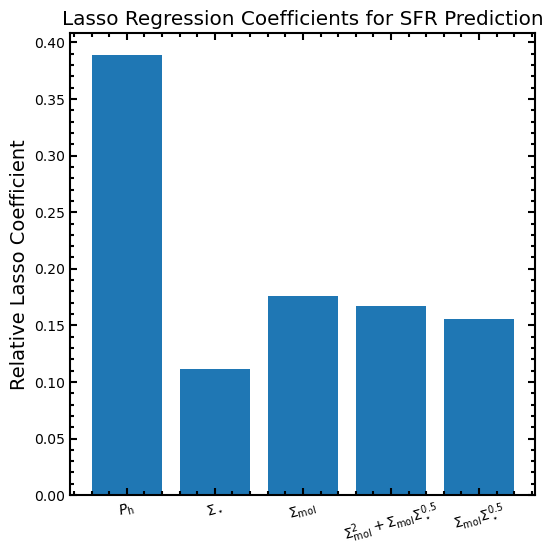

In [163]:
labels = [r'$P_\mathrm{h}$',r'$\Sigma_\star$',r'$\Sigma_\mathrm{mol}$',r'$\Sigma_\mathrm{mol}^2 + \Sigma_\mathrm{mol}\Sigma_\star^{0.5}$',r'$\Sigma_\mathrm{mol}\Sigma_\star^{0.5}$']
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(labels, norm_coef)
ax.set_ylabel('Relative Lasso Coefficient')
#ax.set_yscale('log')
ax.set_title('Lasso Regression Coefficients for SFR Prediction')
plt.xticks(rotation=15)
plt.show()

The bar plot shows that the hysdrostatic pressure is the most important feature in our model, exceling over the stellar mass and the molecular gas mass, as well as over the two test features represented by the rightmost bars in the plot. This shows once again that the hydorstatic pressure is the best predictor of star formation in the galaxies in the ACA-EDGE survey.

## References

1. Barrera-Ballesteros, J. K. et. al. *The EDGE-CALIFA survey: self-regulation of star formation at kpc scales* (2021). DOI: [10.1093/mnras/stab755](https://academic.oup.com/mnras/article/503/3/3643/6169731)

2. Ellison, S. L. et. al. *The ALMaQUEST Survey XI: a strong but non-linear relationship between star formation and dynamical equilibrium pressure* (2024). DOI: [10.1093/mnras/stad3778](https://doi.org/10.1093/mnras/stad3778)

3. Sánchez, S. F. et. al. *The EDGE–CALIFA survey: the local and global relations between $Σ_*$, $Σ_{SFR}$, and $Σ_{mol}$ that regulate star formation* (2021). DOI: [10.1093/mnras/stab755](https://academic.oup.com/mnras/article/503/2/1615/6179769)